## Boosting CV

### Part 1 - Implement Adaboost Classifier

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from boosting_soln import *
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
np.random.seed(1) # consistent results
   
# path may need to be modified based on relative location of spam.csv
df = pd.read_csv('../data/master.csv')

mask_pass = df['PlayType'] == 'PASS'
mask_rush = (df['PlayType'] == 'RUSH') | (df['IsRush'] == 1)
df = df[mask_pass | mask_rush]

/Users/Philip/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,23,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Make a numpy array called y containing the IsPass values
y = df.pop('IsPass').values

# Get dummies for categorical data (try label encoding)
categorical = ['OffenseTeam', 'DefenseTeam', 'Formation', 'Location', 'Month', 'Quarter',
                'Surface', 'Weather_cat', 'Coach', 'Offensive_coordinator', 'SeasonYear',
                'Offensive_scheme', 'Defensive_coordinator', 'Defensive_alignment', 'Down'
                ]

df = pd.get_dummies(df, columns=categorical)

# Drop columns that won't be trained on
drop_columns = ['GameId', 'GameDate', 'NextScore', 'Description', 'TeamWin', 'Minute', 'Second',
                'Yards', 'PlayType', 'IsRush', 'IsIncomplete', 'IsTouchdown', 'Two_plays_ago',
                'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed', 'IsMeasurement',
                'IsInterception', 'IsFumble', 'IsPenalty', 'IsTwoPointConversionScore',
                'IsTwoPointConversionSuccessful', 'RushDirection', 'YardLineFixed', 'IsExtraPoint',
                'YardLineDirection', 'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay',
                'PenaltyType', 'PenaltyYards', 'Team1_Team2', 'Away_team', 'SeriesFirstDown',
                'Home_team', 'IsFieldGoal', 'IsSafety', 'Home_score', 'Away_score', 'Last_play',
                ]

df = df.drop(drop_columns, axis=1)

# Make a 2 dimensional numpy array containing the feature data (everything except the labels)
X = df.values

# Use sklearn's train_test_split to split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Part 2 - Estimator Complexity

In [14]:
def misclassification_rate(y_pred, y):
    '''
    INPUT:
        - y: numpy array, true labels
        - y_pred: numpy array, predicted labels
    '''
    return float((y_pred != y).sum())/len(y)

In [15]:
def stage_score_plot(estimator, X_train, X_test, y_train, y_test):
    '''
        Parameters: estimator: GradientBoostingClassifier or 
                               AdaBoostClassifier
                    X_train: 2d numpy array
                    y_train: 1d numpy array
                    X_test: 2d numpy array
                    y_test: 1d numpy array

        Returns: A plot of the number of iterations vs the misclassification rate 
        for the model for both the training set and test set.
    '''
    estimator.fit(X_train, y_train)
    name = estimator.__class__.__name__.replace('Classifier', '')
    label_str = name
    if "Gradient" in name: 
        md = estimator.max_depth
        label_str += ", max depth: {0}".format(md)
    
    # initialize 
    test_scores = np.zeros((estimator.n_estimators,), dtype=np.float64)
    # Get test score from each boost
    for i, y_test_pred in enumerate(estimator.staged_predict(X_test)):
        test_scores[i] = misclassification_rate(y_test, y_test_pred)
    plt.plot(test_scores, alpha=.5, label=label_str, ls = '-', marker = 'o', ms = 3)
    plt.ylabel('Misclassification rate', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

In [ ]:
n_trees = 100 
models = [AdaBoostClassifier(n_estimators=n_trees),
          GradientBoostingClassifier(n_estimators=n_trees),
          GradientBoostingClassifier(n_estimators=n_trees, max_depth = 10),
          GradientBoostingClassifier(n_estimators=n_trees, max_depth = 100)
          ]
for model in models: 
    stage_score_plot(model, X_train, X_test, y_train, y_test)
plt.legend()
plt.title('Investigate model complexity on Test set', fontsize=14, fontweight='bold')
plt.grid(color='grey', linestyle='dotted') 

#### Grid search - coarse first, then fine

In [6]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')  # annoying warnings

In [7]:
model_best = grid_search(X_train, y_train)


4) Part 2 grid search
Starting grid search - coarse (will take several minutes)
Coarse search best parameters:
learning_rate        | 0.1
min_samples_leaf     | 10
n_estimators         | 100
subsample            | 1.0
random_state         | 1
max_features         | sqrt
max_depth            | 10
Coarse search best score: 0.953

Starting grid search - fine
Fine search best parameters:
learning_rate        | 0.05
min_samples_leaf     | 2
n_estimators         | 100
subsample            | 1.0
random_state         | 1
max_features         | sqrt
max_depth            | 10
Fine search best score: 0.950
Returning best model.


In [8]:
y_pred = model_best.predict(X_test)
mc_rate = misclassification_rate(y_pred, y_test)
print "4) The misclassification rate is {0:0.3f}".format(mc_rate)

4) The misclassification rate is 0.036


### Part 3 - Feature importance and partial dependency plots

In [9]:
import requests
import itertools
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

In [10]:
feature_importances = model_best.feature_importances_
top10_colindex = np.argsort(feature_importances)[::-1][0:10]
feature_importances = feature_importances[top10_colindex]
feature_importances = feature_importances / float(feature_importances.max()) #normalize

In [11]:
all_feature_names = get_feature_names()
feature_names = list(all_feature_names[top10_colindex])

In [12]:
print "1) Sorted features, their relative importances, and their indices:" 
for fn, fi, indx in zip(feature_names, feature_importances, top10_colindex):
    print "{0:<30s} | {1:6.3f} | {2}".format(fn, fi, indx)

1) Sorted features, their relative importances, and their indices:
char_freq_!                    |  1.000 | 51
capital_run_length_longest     |  0.683 | 55
char_freq_$                    |  0.653 | 52
capital_run_length_average     |  0.650 | 54
word_freq_remove               |  0.600 | 6
word_freq_free                 |  0.595 | 15
capital_run_length_total       |  0.584 | 56
word_freq_you                  |  0.566 | 18
word_freq_your                 |  0.475 | 20
word_freq_hp                   |  0.474 | 24


### 1) Feature importance bar plot

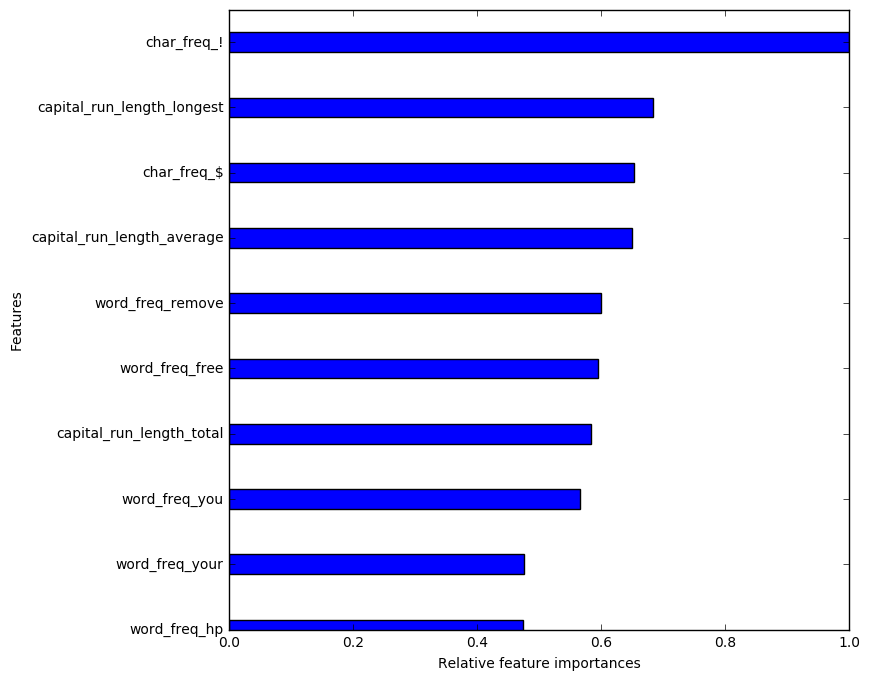

In [13]:
y_ind = np.arange(9, -1, -1) # 9 to 0
fig = plt.figure(figsize=(8, 8))
plt.barh(y_ind, feature_importances, height = 0.3, align='center')
plt.ylim(y_ind.min() + 0.5, y_ind.max() + 0.5)
plt.yticks(y_ind, feature_names)
plt.xlabel('Relative feature importances')
plt.ylabel('Features');

### 2) Partial dependency plots

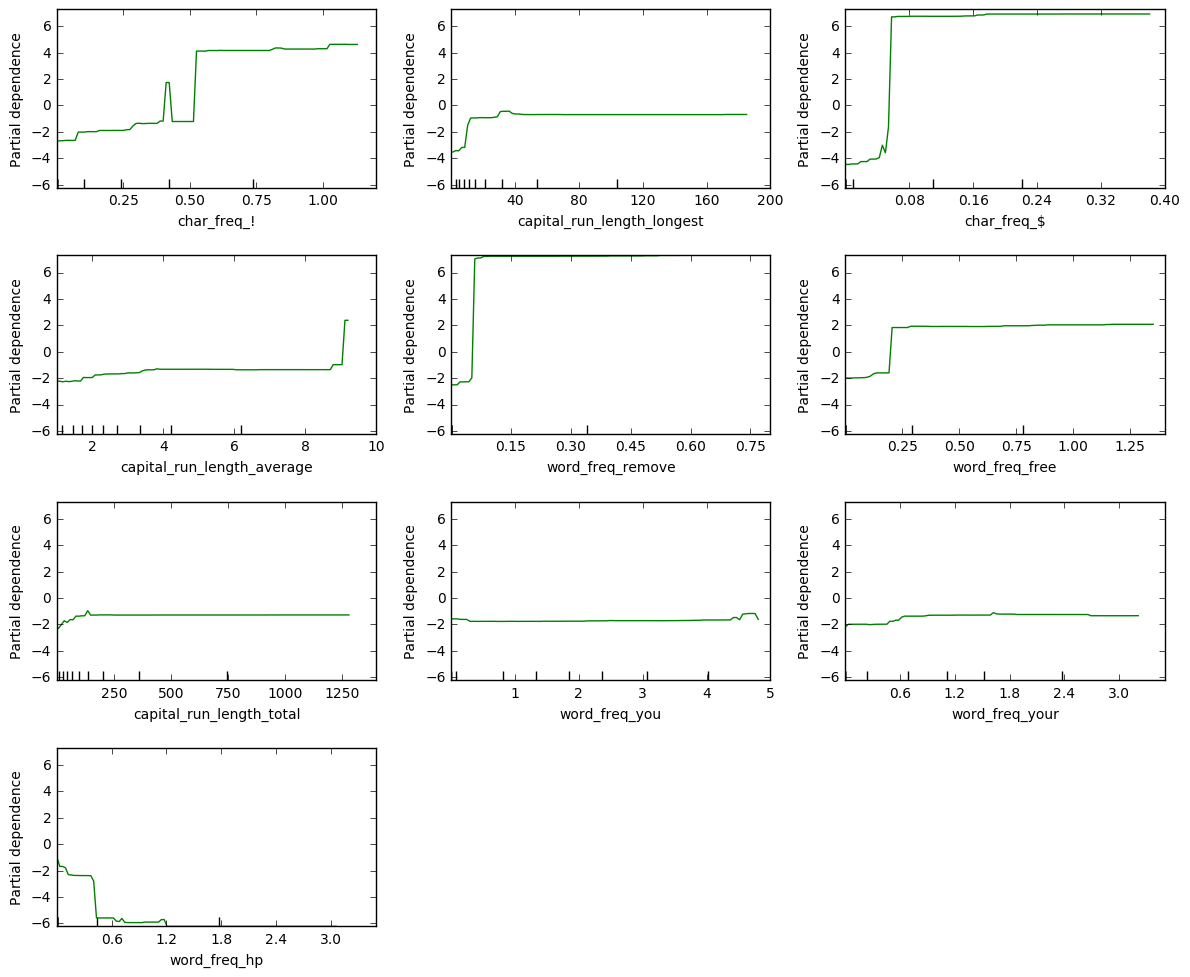

In [14]:
plot_partial_dependence(model, X_train, top10_colindex,
                        feature_names = all_feature_names,
                        figsize=(12,10))
plt.tight_layout();

In [15]:
answer_description_3_2()


2) Partial dependency plots show the effect of a given feature on
the target variable after accounting for the average effect of all
the other features.  The regions where the graph is flat means
that there isn't much of a relationship between the target (in
this case, whether it's spam or not) and the feature investigated
by that plot in that region.  However, in areas where it isn't flat
the target is more dependent on the feature in question.

As shown in the plots, as the 'char_freq_!' and 'char_freq_$'
feature values increase, the chance of spam (value 1) increases
This is also true for 'capital_run_length_total' for values <
about 125 characters, however after that it doesn't make much
difference.  The other plots can be interpreted in a similar way.


### 3) Examine partial dependence of two features on the target

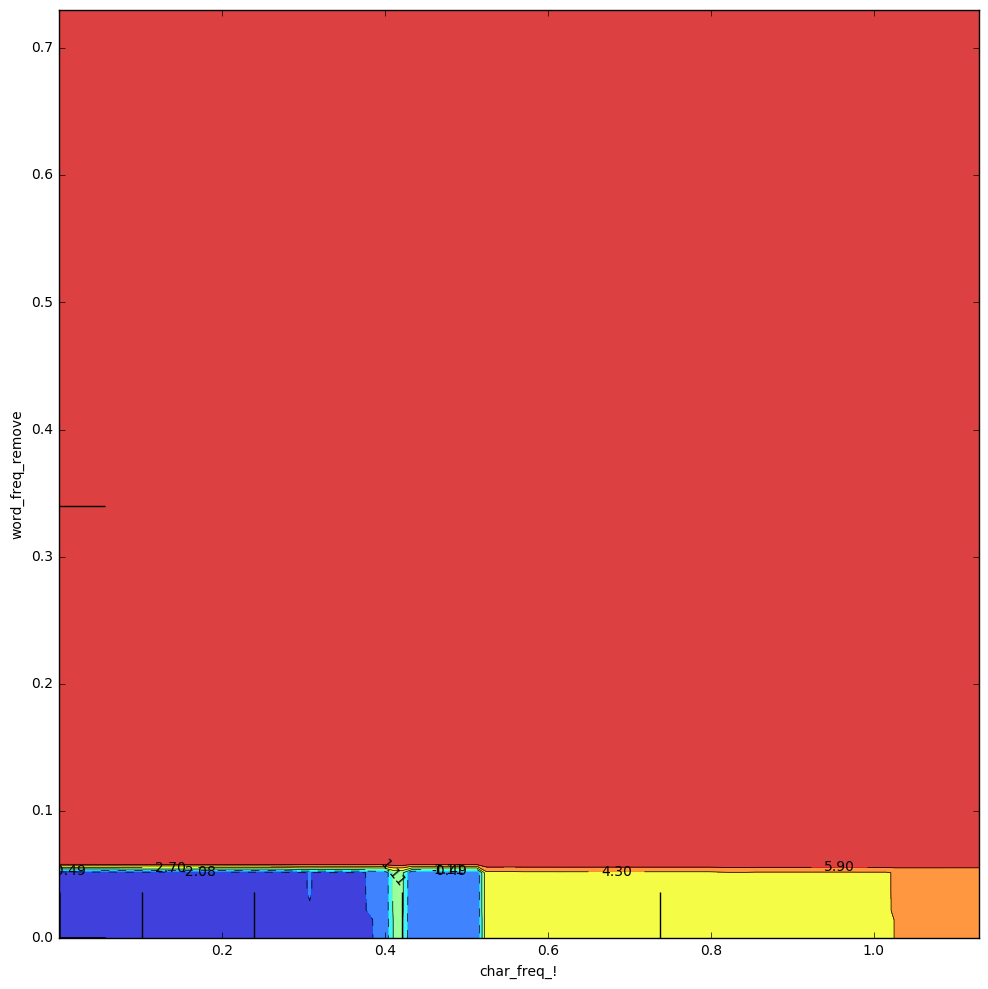

In [16]:
plot_partial_dependence(model, X_train, [(51, 6)],
                        feature_names = all_feature_names,
                        figsize=(10,10))
plt.tight_layout();

#### 3D partial dependency plot

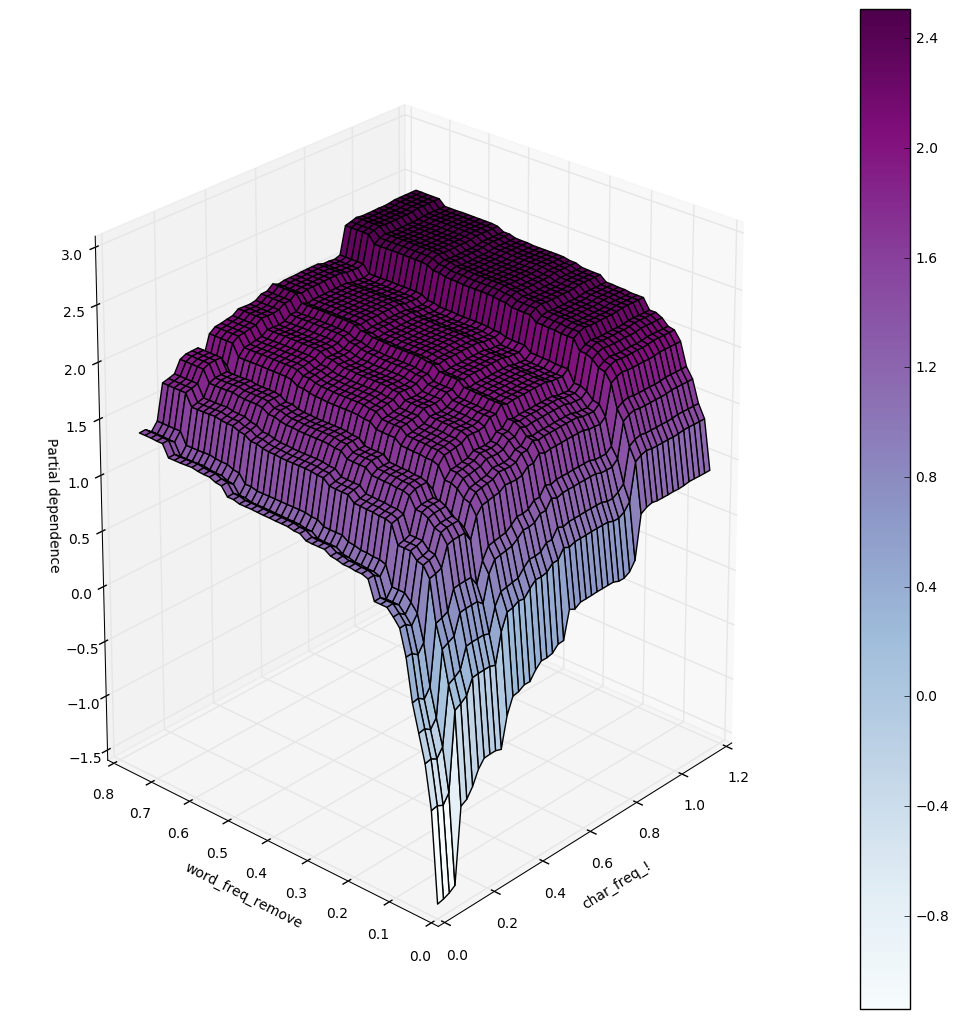

In [17]:
fig = plt.figure(figsize = (10, 10))
ax = Axes3D(fig)
target_feature = (51, 6) # indices of features to plot
pdp, (x_axis, y_axis) = partial_dependence(model_best, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(all_feature_names[target_feature[0]])
ax.set_ylabel(all_feature_names[target_feature[1]])
ax.set_zlabel('Partial dependence')
ax.view_init(elev=22, azim=222)
plt.colorbar(surf)
plt.subplots_adjust(top=0.9)